<a href="https://colab.research.google.com/github/muah48157/number-plate-detector/blob/main/Number_Plate_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install kagglehub ultralytics matplotlib numpy opencv-python

import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Image, display
import xml.etree.ElementTree as ET

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Download the dataset
dataset_path = kagglehub.dataset_download("aslanahmedov/number-plate-detection")
print(f"Dataset downloaded to: {dataset_path}")

# Let's properly examine the structure
def list_dirs(startpath):
    print("\nFull directory structure:")
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # print first 5 files max
            print(f"{subindent}{f}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")

list_dirs(dataset_path)

# Now let's analyze the contents
images_dir = os.path.join(dataset_path, "images")
test_dir = os.path.join(dataset_path, "TEST")

print("\nKey findings:")
print(f"- Main images directory contains {len(os.listdir(images_dir))} files")
print(f"- TEST directory contains: {os.listdir(test_dir)}")

# Let's check the file types in images directory
image_files = []
xml_files = []
for f in os.listdir(images_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_files.append(f)
    elif f.lower().endswith('.xml'):
        xml_files.append(f)

print(f"\nFound {len(image_files)} image files and {len(xml_files)} XML annotation files")

# Check if we have matching pairs
paired_files = []
for img in image_files:
    base = os.path.splitext(img)[0]
    if f"{base}.xml" in xml_files:
        paired_files.append(img)

print(f"\nFound {len(paired_files)} properly paired image/annotation files")
print(f"Sample pairs: {paired_files[:3]}")

# Verify the data.yaml content
yaml_path = os.path.join(dataset_path, "data.yaml")
if os.path.exists(yaml_path):
    print("\nContents of data.yaml:")
    with open(yaml_path, 'r') as f:
        print(f.read())
else:
    print("\nNo data.yaml file found")

100%|██████████| 413M/413M [00:19<00:00, 22.7MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/aslanahmedov/number-plate-detection/versions/30

Full directory structure:
30/
    data.yaml
    TEST/
        TEST.mp4
        TEST.jpeg
    images/
        N88.jpeg
        N128.jpeg
        N190.xml
        N187.jpeg
        N36.xml
        ... and 448 more files

Key findings:
- Main images directory contains 453 files
- TEST directory contains: ['TEST.mp4', 'TEST.jpeg']

Found 228 image files and 225 XML annotation files

Found 225 properly paired image/annotation files
Sample pairs: ['N88.jpeg', 'N128.jpeg', 'N187.jpeg']

Contents of data.yaml:
train: data_images/train
val: data_images/test
nc: 1
names: [
    'license_plate'
]



Visualizing samples from the dataset:


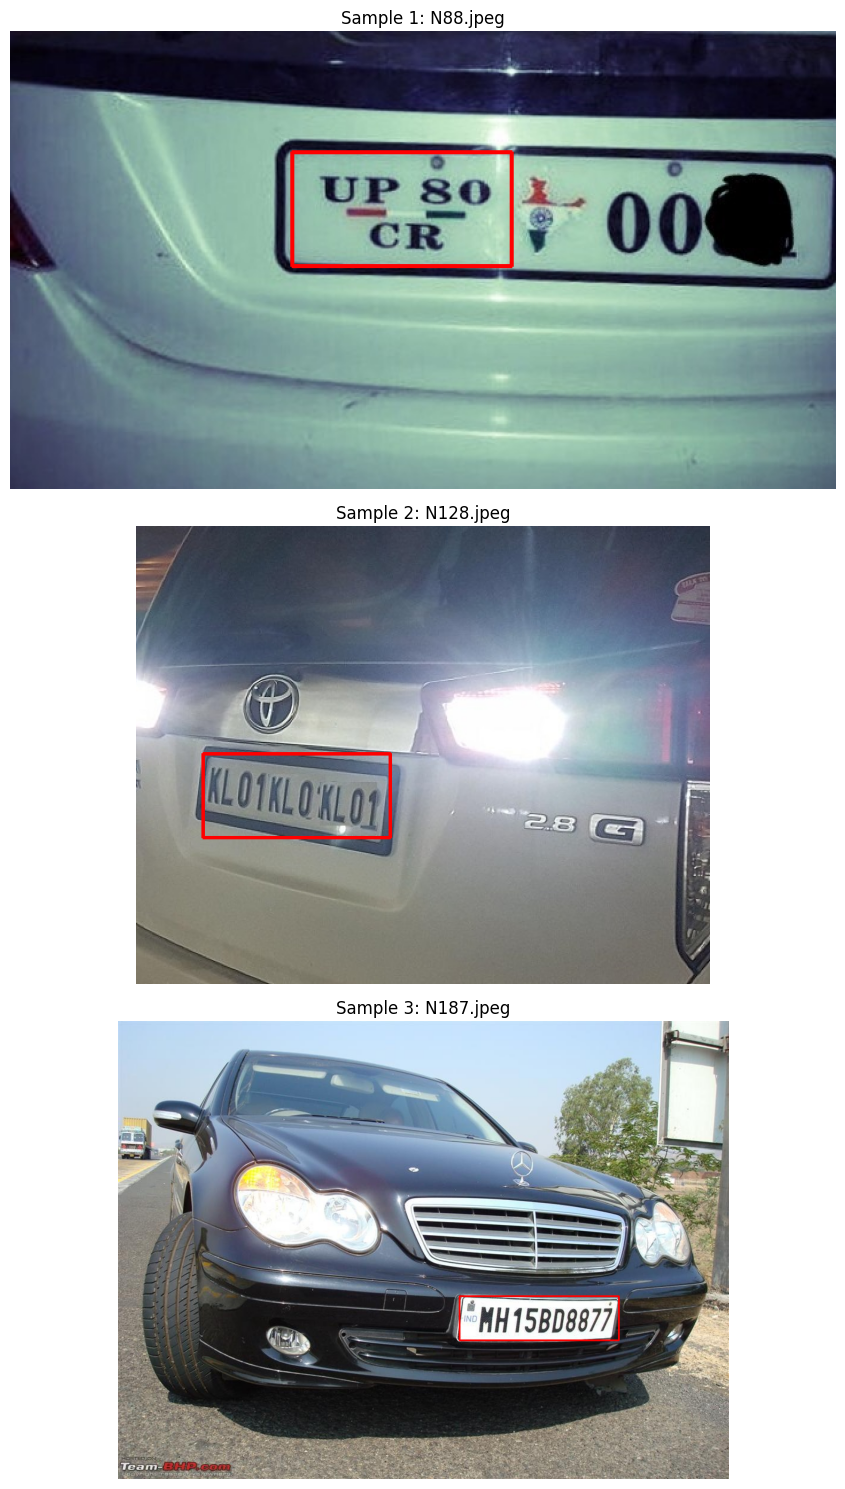

In [3]:
def plot_samples_from_directory(directory, num_samples=3):
    """Plot samples from the combined image/annotation directory"""
    image_files = [f for f in os.listdir(directory)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

    plt.figure(figsize=(15, 5*num_samples))

    for i, img_file in enumerate(image_files):
        # Load image
        img_path = os.path.join(directory, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load corresponding annotation
        base_name = os.path.splitext(img_file)[0]
        annotation_path = os.path.join(directory, f"{base_name}.xml")

        if not os.path.exists(annotation_path):
            print(f"Warning: No annotation found for {img_file}")
            plt.subplot(num_samples, 1, i+1)
            plt.imshow(img)
            plt.title(f"Sample {i+1}: {img_file} (no annotation)")
            plt.axis('off')
            continue

        # Parse XML
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Draw bounding boxes
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        # Plot
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        plt.title(f"Sample {i+1}: {img_file}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from the main directory
print("\nVisualizing samples from the dataset:")
plot_samples_from_directory(os.path.join(dataset_path, "images"))

In [4]:
def prepare_yolo_dataset_single_dir(source_dir, output_base='/kaggle/working', test_size=0.2):
    """Prepare YOLO dataset from a single directory containing both images and annotations"""
    import shutil
    from sklearn.model_selection import train_test_split

    # Create YOLO directory structure in a writable location
    yolo_dir = os.path.join(output_base, "yolo_dataset")
    os.makedirs(yolo_dir, exist_ok=True)

    # Create train/val directories
    train_dir = os.path.join(yolo_dir, 'train')
    val_dir = os.path.join(yolo_dir, 'val')
    os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)

    # Get all image files with corresponding annotations
    paired_files = []
    for f in os.listdir(source_dir):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            base = os.path.splitext(f)[0]
            if f"{base}.xml" in os.listdir(source_dir):
                paired_files.append(f)

    print(f"\nFound {len(paired_files)} valid image-annotation pairs")

    # Split into train and validation
    train_files, val_files = train_test_split(paired_files, test_size=test_size, random_state=42)

    def process_files(files, dest_dir):
        """Process files and copy to destination directory"""
        for img_file in files:
            base_name = os.path.splitext(img_file)[0]

            # Copy image
            src_img_path = os.path.join(source_dir, img_file)
            dst_img_path = os.path.join(dest_dir, 'images', img_file)
            shutil.copy(src_img_path, dst_img_path)

            # Convert annotation
            xml_file = os.path.join(source_dir, f"{base_name}.xml")

            # Parse XML
            tree = ET.parse(xml_file)
            root = tree.getroot()

            # Get image dimensions
            size = root.find('size')
            img_width = int(size.find('width').text)
            img_height = int(size.find('height').text)

            # Create YOLO format annotation
            yolo_ann = []
            for obj in root.findall('object'):
                # Check object name (handle different possible names)
                obj_name = obj.find('name').text.lower()
                if 'plate' not in obj_name and 'license' not in obj_name:
                    continue

                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                # Convert to YOLO format
                x_center = ((xmin + xmax) / 2) / img_width
                y_center = ((ymin + ymax) / 2) / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                # Class 0 for license plate
                yolo_ann.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

            # Write annotation file
            if yolo_ann:
                ann_file = os.path.join(dest_dir, 'labels', f"{base_name}.txt")
                with open(ann_file, 'w') as f:
                    f.write('\n'.join(yolo_ann))

    # Process files
    print(f"\nProcessing {len(train_files)} training files...")
    process_files(train_files, train_dir)
    print(f"Processing {len(val_files)} validation files...")
    process_files(val_files, val_dir)

    # Create dataset.yaml
    yaml_content = f"""
train: {os.path.join(yolo_dir, 'train', 'images')}
val: {os.path.join(yolo_dir, 'val', 'images')}

nc: 1
names: ['license_plate']
"""

    yaml_path = os.path.join(yolo_dir, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content.strip())

    return yaml_path

# Prepare YOLO dataset - output to writable location
yaml_path = prepare_yolo_dataset_single_dir(
    source_dir=os.path.join(dataset_path, "images"),
    output_base='/kaggle/working'  # This is the writable directory in Kaggle
)
print(f"\nYOLO dataset prepared. Configuration file: {yaml_path}")


Found 225 valid image-annotation pairs

Processing 180 training files...
Processing 45 validation files...

YOLO dataset prepared. Configuration file: /kaggle/working/yolo_dataset/dataset.yaml


In [5]:
# Initialize YOLOv8 model
model = YOLO("yolov8n.pt")  # Using nano version for faster training

# Train the model using our prepared dataset
results = model.train(
    data=yaml_path,  # Using the path we just created
    epochs=50,
    imgsz=640,
    batch=16,
    name='number_plate_detection',
    optimizer='auto',
    device='0',
    workers=8,
    single_cls=True
)

# Save the trained model
model.save(os.path.join('/kaggle/working', "number_plate_model.pt"))
print("Training completed and model saved.")

100%|██████████| 6.25M/6.25M [00:00<00:00, 221MB/s]


Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=number_plate_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 87.8MB/s]

Overriding class names with single class.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 147MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1165.1±850.7 MB/s, size: 67.3 KB)


train: Scanning /kaggle/working/yolo_dataset/train/labels... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 2373.78it/s]

train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 280.7±180.5 MB/s, size: 235.4 KB)


val: Scanning /kaggle/working/yolo_dataset/val/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 1411.28it/s]

val: New cache created: /kaggle/working/yolo_dataset/val/labels.cache


Plotting labels to runs/detect/number_plate_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/number_plate_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.05G      1.526      3.606      1.419          8        640: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         45         45    0.00326      0.978       0.71      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.29G      1.272      2.042       1.07         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         45         45    0.00333          1      0.848      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.3G      1.246      1.816      1.113          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         45         45      0.233      0.844      0.757      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.32G       1.35      1.872      1.127          5        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         45         45      0.652      0.416      0.528      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.35G      1.271      1.708      1.099          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         45         45      0.667      0.378      0.519      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.37G      1.307      1.634      1.134          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         45         45      0.732      0.668      0.728      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.38G      1.305      1.466      1.177         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         45         45       0.51      0.602      0.527      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.4G      1.308      1.513      1.173         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         45         45      0.531      0.578      0.586      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.42G      1.286      1.448      1.153          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         45         45      0.835        0.8      0.868      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.43G      1.191      1.354       1.09          3        640: 100%|██████████| 12/12 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         45         45      0.902      0.778      0.886      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.45G      1.361      1.292      1.203          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         45         45      0.756      0.827      0.782      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.47G      1.195      1.219       1.16          5        640: 100%|██████████| 12/12 [00:02<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         45         45      0.832      0.889      0.913      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.48G      1.141      1.168      1.086          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         45         45       0.95      0.933      0.959      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.5G      1.211      1.171      1.105          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         45         45      0.869      0.911      0.919      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.52G      1.198      1.047      1.142          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         45         45      0.949      0.933      0.959      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.54G      1.141       0.99      1.098         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         45         45      0.968      0.911      0.937      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.55G      1.061     0.9407      1.054          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         45         45       0.97      0.956      0.946      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.57G      1.102     0.9473      1.059          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         45         45       0.97      0.933      0.964      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.59G      1.055     0.9305      1.068         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         45         45      0.976      0.893      0.966      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.6G      1.042     0.8932      1.034          3        640: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         45         45       0.97      0.933      0.979      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.62G      1.067     0.8679      1.051         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         45         45       0.97      0.911      0.981      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.64G      1.095     0.8813      1.041          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


                   all         45         45      0.972      0.911      0.963      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.65G      1.025     0.8586      1.056          5        640: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


                   all         45         45      0.954      0.925      0.984      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.67G      1.117     0.8378      1.095          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         45         45      0.934      0.938      0.984      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.69G     0.9668     0.7558       1.01          9        640: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         45         45       0.95      0.956      0.987      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.71G     0.9951     0.7837      1.025          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         45         45      0.978      0.992       0.99      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.72G      1.017     0.7543      1.032         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         45         45      0.956       0.97      0.986      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.74G      1.042     0.7863      1.118          5        640: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         45         45       0.97      0.978      0.992      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.76G     0.9653     0.7528      1.024          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         45         45      0.933          1      0.992      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.78G     0.9777     0.7046      1.021          9        640: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         45         45      0.975      0.978      0.987      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.79G      0.911     0.7227      1.021          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         45         45      0.947      0.978      0.989      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.81G     0.9364     0.7033     0.9995          9        640: 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         45         45      0.956      0.977      0.989      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.83G     0.9219     0.7139      1.003          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         45         45      0.915      0.953      0.982      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.85G     0.9315      0.712     0.9978          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         45         45      0.929      0.956      0.981       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.86G     0.8711     0.6602     0.9619          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

                   all         45         45      0.974      0.978      0.991      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.88G     0.9031      0.701     0.9941          5        640: 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         45         45      0.969      0.956       0.99      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.89G     0.9001     0.6727          1          9        640: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         45         45      0.935          1      0.989      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.91G     0.8752     0.6362     0.9708          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         45         45      0.954          1       0.99      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.93G     0.8421     0.6363     0.9492          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         45         45      0.977          1      0.991      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.95G     0.9158      0.649     0.9845          5        640: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         45         45      0.967          1      0.992      0.718


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.96G     0.7718     0.6412     0.9432          4        640: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         45         45      0.978      0.998      0.991      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.98G      0.769     0.6136      0.938          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         45         45      0.952          1      0.991      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         3G     0.8024      0.608     0.9658          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         45         45      0.932          1      0.982      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.01G     0.8174      0.613     0.9681          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         45         45      0.978      0.977      0.978      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.03G     0.7142     0.5621     0.9185          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         45         45      0.976      0.978      0.978      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.05G     0.7497     0.5593     0.9367          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         45         45      0.978      0.976       0.98      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.06G     0.7195     0.5707     0.9001          4        640: 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         45         45      0.957      0.999      0.982      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.08G     0.6834      0.548     0.9225          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         45         45      0.956          1      0.985      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       3.1G     0.6817     0.5446     0.9137          4        640: 100%|██████████| 12/12 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         45         45      0.957      0.999       0.99      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.12G     0.6863     0.5352      0.915          4        640: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         45         45      0.957      0.998      0.992      0.706



50 epochs completed in 0.056 hours.
Optimizer stripped from runs/detect/number_plate_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/number_plate_detection/weights/best.pt, 6.2MB

Validating runs/detect/number_plate_detection/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


                   all         45         45      0.956          1      0.985      0.735
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/number_plate_detection
Training completed and model saved.


Model loaded successfully from: /kaggle/working/number_plate_model.pt

Testing on sample image: /kaggle/working/yolo_dataset/val/images/N195.jpeg

image 1/1 /kaggle/working/yolo_dataset/val/images/N195.jpeg: 480x640 1 item, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


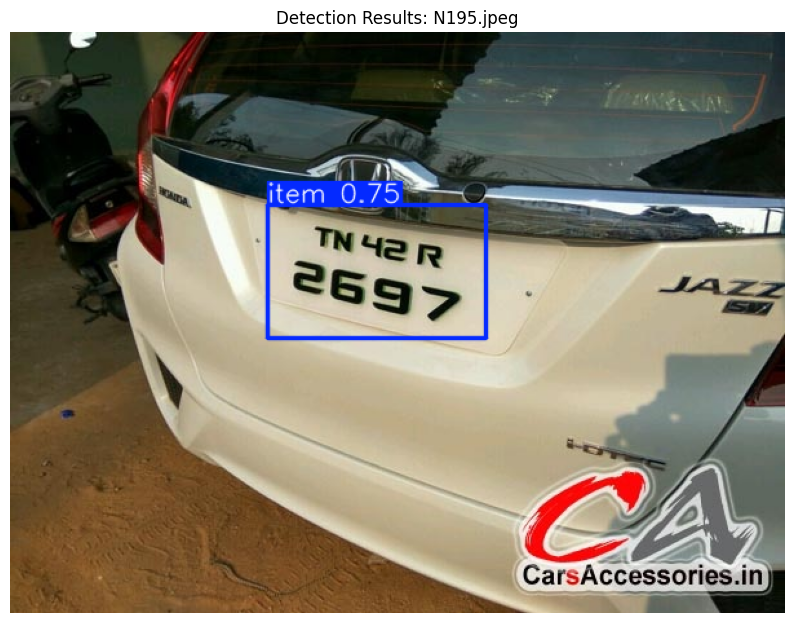


Detection Results for /kaggle/working/yolo_dataset/val/images/N195.jpeg:
Detected 1 license plate(s)

License Plate 1:
- Confidence: 0.7536
- Bounding Box Coordinates (xmin, ymin, xmax, ymax): [199.04266357421875, 134.62130737304688, 368.19891357421875, 237.0364227294922]

Upload a number plate image for detection:


Saving photo-1534706438758-534c634c4591.jpg to photo-1534706438758-534c634c4591.jpg

image 1/1 /content/photo-1534706438758-534c634c4591.jpg: 640x448 6 items, 41.0ms
Speed: 3.2ms preprocess, 41.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


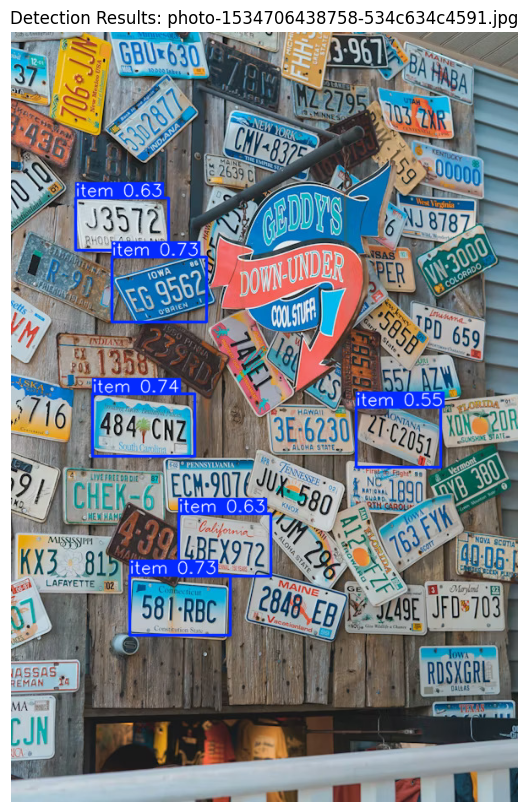


Detection Results for photo-1534706438758-534c634c4591.jpg:
Detected 6 license plate(s)

License Plate 1:
- Confidence: 0.7379
- Bounding Box Coordinates (xmin, ymin, xmax, ymax): [96.775146484375, 428.6555480957031, 217.90492248535156, 502.5445251464844]

License Plate 2:
- Confidence: 0.7315
- Bounding Box Coordinates (xmin, ymin, xmax, ymax): [119.85455322265625, 266.5231018066406, 231.74449157714844, 343.1117858886719]

License Plate 3:
- Confidence: 0.7284
- Bounding Box Coordinates (xmin, ymin, xmax, ymax): [140.66172790527344, 643.8710327148438, 259.1262512207031, 714.1177978515625]

License Plate 4:
- Confidence: 0.6274
- Bounding Box Coordinates (xmin, ymin, xmax, ymax): [198.91712951660156, 570.7765502929688, 307.2181701660156, 644.9830932617188]

License Plate 5:
- Confidence: 0.6269
- Bounding Box Coordinates (xmin, ymin, xmax, ymax): [76.7249526977539, 196.0251007080078, 186.03233337402344, 258.9744873046875]

License Plate 6:
- Confidence: 0.5522
- Bounding Box Coordinat

In [9]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image as PILImage  # Renamed to avoid conflict
from IPython.display import display

# Load the model (using the path we found)
model_path = '/kaggle/working/number_plate_model.pt'
model = YOLO(model_path)
print(f"Model loaded successfully from: {model_path}")

def predict_and_visualize(image_path, conf=0.5):
    """
    Make predictions on an image and visualize the results
    Args:
        image_path: Path to the input image
        conf: Confidence threshold (default: 0.5)
    """
    # Verify image exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at: {image_path}")

    # Make prediction
    results = model.predict(image_path, conf=conf)

    # Visualize results
    for r in results:
        # Create plot
        im_array = r.plot()  # plot a BGR numpy array of predictions

        # Convert to RGB and display
        plt.figure(figsize=(10, 10))
        plt.imshow(im_array[..., ::-1])  # Convert BGR to RGB
        plt.axis('off')
        plt.title(f"Detection Results: {os.path.basename(image_path)}")
        plt.show()

        # Print detection information
        print(f"\nDetection Results for {image_path}:")
        print(f"Detected {len(r.boxes)} license plate(s)")
        for i, box in enumerate(r.boxes):
            print(f"\nLicense Plate {i+1}:")
            print(f"- Confidence: {box.conf.item():.4f}")
            print(f"- Bounding Box Coordinates (xmin, ymin, xmax, ymax): {box.xyxy.tolist()[0]}")

    return results

# Test the function
val_images_dir = '/kaggle/working/yolo_dataset/val/images'
if os.path.exists(val_images_dir):
    sample_image = os.listdir(val_images_dir)[0]  # Get first image
    test_image_path = os.path.join(val_images_dir, sample_image)
    print(f"\nTesting on sample image: {test_image_path}")
    results = predict_and_visualize(test_image_path)
else:
    print("Validation images directory not found")

# Alternative for custom images
try:
    from google.colab import files
    print("\nUpload a number plate image for detection:")
    uploaded = files.upload()
    for filename in uploaded.keys():
        results = predict_and_visualize(filename)
except ImportError:
    print("\nNot running in Colab. To test custom images, please:")
    print("1. Upload your image to the environment")
    print("2. Update the test_image_path variable")
    # Example:
    # test_image_path = '/kaggle/working/my_test_image.jpg'
    # results = predict_and_visualize(test_image_path)

In [10]:
from ultralytics import YOLO

# Load your trained model (replace with your actual model path)
model = YOLO('/kaggle/working/number_plate_model.pt')  # or wherever your model is saved

# Save the model in a standard format
model.save('/content/number_plate_model.pt')  # Saving to /content for easy access

# Export to different formats (optional)
model.export(format='onnx')  # Creates '/content/number_plate_model.onnx'
model.export(format='torchscript')  # Creates '/content/number_plate_model.torchscript'

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/kaggle/working/number_plate_model.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 241.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 148.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 186.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 159.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 349.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 15.6s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for upd

'/kaggle/working/number_plate_model.torchscript'